In [1]:
!git clone https://github.com/rickiepark/nlp-with-transformers.git
%cd nlp-with-transformers
from install import *
install_requirements(chapter=2)

Cloning into 'nlp-with-transformers'...
remote: Enumerating objects: 597, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 597 (delta 10), reused 2 (delta 1), pack-reused 569
Receiving objects: 100% (597/597), 57.73 MiB | 19.70 MiB/s, done.
Resolving deltas: 100% (298/298), done.
/content/nlp-with-transformers
⏳ Installing base requirements ...
✅ Base requirements installed!
Using transformers v4.30.2
Using datasets v2.13.1
Using accelerate v0.20.3
Using sentencepiece v0.1.99
Using umap v0.5.3
No GPU was detected! This notebook can be *very* slow without a GPU 🐢
Go to Runtime > Change runtime type and select a GPU hardware accelerator.


텍스트 분류는 NLP에서 매우 일반적인 작업이다.  
감성 분석 또한 이의 일부이며 매우 유용한다.  

</br>
이 장에서는 BERT의 한 종류인 DistilBERT를 사용해 구현해보겠다.  

</br>
또한 허깅페이스의 핵심 라이브러리인 데이터셋, 토크나이저, 트랜스포머를 사용해 보겠다.


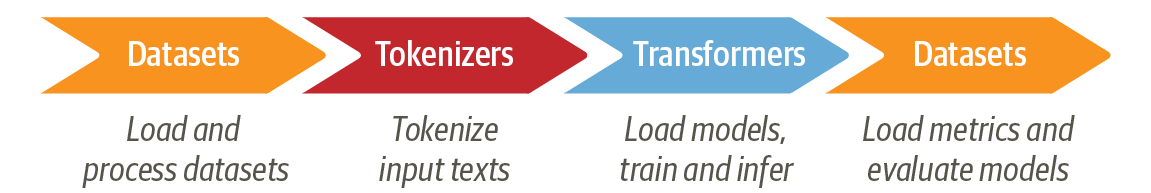

---
# 데이터 셋
긍정적과 부정적으로 나뉘는 대부분의 감정 분석과는 달리  
이번에 사용할 데이터 셋은 분노, 혐오, 두려움, 기쁨, 슬픔, 놀람  
6개의 감정을 사용하는 데이터 셋을 사용한다.  



In [2]:
from datasets import list_datasets

all_datasets = list_datasets()
print(f"현재 허브에는 {len(all_datasets)}개의 데이터셋이 있다.")
print(f"처음 10개 데이터 셋 : {all_datasets[:10]}")

<ipython-input-2-5c4ff1dcd749>:3: FutureWarning: list_datasets is deprecated and will be removed in the next major version of datasets. Use 'huggingface_hub.list_datasets' instead.
  all_datasets = list_datasets()


현재 허브에는 45981개의 데이터셋이 있다.
처음 10개 데이터 셋 : ['acronym_identification', 'ade_corpus_v2', 'adversarial_qa',
'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'ai2_arc', 'air_dialogue',
'ajgt_twitter_ar', 'allegro_reviews']


데이터셋마다 이름이 있다. load_dataset()함수로 emotion 데이터 셋을 로드해보자

In [3]:
from datasets import load_dataset

emotions = load_dataset("emotion")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

이 emotions라는 객체는 파이썬 딕셔너리와 비슷한다.  
각 키는 다른 분할에 상응하며 일반적인 딕셔너리 사용법을 사용할 수 있다.

In [5]:
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

Dataset 클래스 객체를 반환했다.

In [6]:
len(train_ds)

16000

출력 결과, 길이는 16000, 위에도 나와있다.  
인덱스로 개별 샘플을 참조해보자

In [7]:
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

한 개의 행이 하나의 딕셔너리로 표현된다.  
0번째 샘플은 i didnt feel humiliated  
즉, 나는 굴욕감을 느끼지 않았다. 라는 의미를 가진다.  

In [8]:
train_ds.column_names

['text', 'label']

앞의 개별 샘플이 text와 label로 구분된 것 처럼  
출력 결과도 text와 label인 것을 볼 수 있는데  
이는 트윗과 감정을 의미한다.  

In [9]:
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness',
'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


위 출력을 통해 라벨에 어떤 감정을 의미하는지 알 수 있다.  
아까 0번 샘플의 label값은 0이었는데, 이는 sadness를 의미하는 것으로 보인다.  

이제, 샘플을 여러개 가져와보자

In [10]:
print(train_ds[:5])

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so
damned hopeful just from being around someone who cares and is awake', 'im
grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic
about the fireplace i will know that it is still on the property', 'i am feeling
grouchy'], 'label': [0, 0, 3, 2, 3]}


5개의 샘플을 가져왔다.  
내용은 다음과 같다.(전부 번역기 결과다.)  

나는 굴욕감을 느끼지 않았다.

나는 단지 관심을 갖고 깨어있는 누군가의 곁에 있는 것만으로도 매우 절망적인 기분에서 빌어먹을 희망으로 바뀔 수 있다.  

나는 게시하기 위해 1분을 잡고 있다. 나는 욕심이 잘못되었다고 느낀다.  

나는 벽난로에 대해 향수를 느끼고 있다. 나는 그것이 여전히 부동산에 있다는 것을 알게 될 것이다.  

나는 기분이 언짢다.

</br>
이에 대하여, 감정은 각각
슬픔, 슬픔, 분노, 사랑, 분노  
로 분류되었다.  
(사실 번역기 결과가 매끄럽지가 않아서, 이게 맞는 분류인지는 잘 모르겠다.)  


# 데이터 프레임
데이터 셋 객체를 판다스의 DataFrame으로 변환하는 것이 편리할 때가 많다.  
변환해보자  

In [11]:
import pandas as pd

emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


앞의 데이터 셋이 판다스에 맞게 출력되었다.  
그런데 라벨이 숫자이면 보기 불편하므로 감정을 적어보자  


In [12]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


본격적으로 분류모델을 만들기 전에 이 데이터 셋에 대해서 좀 더 깊게 알아보자  
샘플 데이터를 쓰기 전에, 이 데이터 셋이 어떤지를 조사하는 것은 중요하므로  
항상 어떤 데이터인지 알아보고 쓰도록 하자  

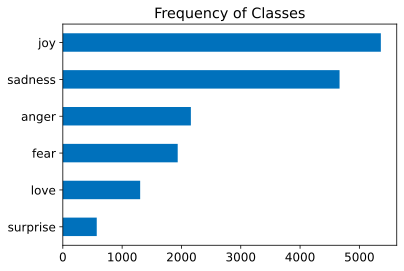

In [13]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

이 데이터 셋은 상당히 편향적이다.  
joy와 sadness만 많이 등장하고 love나 surprise는 적다.  
이러한 불균형은 오버 샘플링이나 언더 샘플링으로 그 수를 맞춰줄 수 있지만  
여기서는 그냥 쓰도록 하겠다.  


## 길이 확인
트랜스포머 모델에는 최대 문맥 크기라는 시퀸스 길이가 있다.  
최대 문맥 크기는 512토큰으로 문단 몇 개 정도가 된다.  
참고로 토큰은 텍스트의 기본 단위다.  
트윗당 단어 분포를 통해 감정에 따른 트윗 길이가 대략 추정된다.  


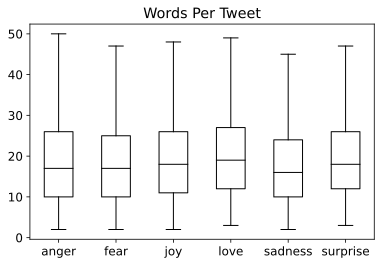

In [14]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False, showfliers=False,
           color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

감정별 트윗의 길이는 대략 15개 정도이다.  

In [15]:
# 리셋용
emotions.reset_format()

## 텍스트에서 토큰으로
주어진 텍스트를 토큰화 해보자  


In [16]:
text = "Tokenizing text is a core task of NLP."
tokenized_text = list(text)
print(tokenized_text)

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ',
'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o',
'f', ' ', 'N', 'L', 'P', '.']


글자단위로 쪼개긴 했지만 모델은 각 문자가 정수로 변환되리라 기대한다.  
이런 과정을 수치화 라고 한다.  
가장 쉬운 방법은 고유한 각 토큰을 고유한 정수로 인코딩 하는 것이다.  

In [17]:
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
print(token2idx)

{' ': 0, '.': 1, 'L': 2, 'N': 3, 'P': 4, 'T': 5, 'a': 6, 'c': 7, 'e': 8, 'f': 9,
'g': 10, 'i': 11, 'k': 12, 'n': 13, 'o': 14, 'r': 15, 's': 16, 't': 17, 'x': 18,
'z': 19}


이제 이걸 정수리스트로 변환한다.

In [18]:
input_ids = [token2idx[token] for token in tokenized_text]
print(input_ids)

[5, 14, 12, 8, 13, 11, 19, 11, 13, 10, 0, 17, 8, 18, 17, 0, 11, 16, 0, 6, 0, 7,
14, 15, 8, 0, 17, 6, 16, 12, 0, 14, 9, 0, 3, 2, 4, 1]


토큰들이 저마다 고유 숫자 식별자로 매핑 되었다.  
이번엔 고유명사를 매핑해보자

In [19]:
categorical_df = pd.DataFrame(
    {"Name": ["Bumblebee", "Optimus Prime", "Megatron"], "Label ID": [0,1,2]})
categorical_df

,Name,Label ID
0,Bumblebee,0
1,Optimus Prime,1
2,Megatron,2


이 방식은 이름사이에 가상의 순서가 만들어 진다는 문제가 있다.  
따라서 다음과 같은 방법을 사용한다.  

In [20]:
pd.get_dummies(categorical_df["Name"])

,Bumblebee,Megatron,Optimus Prime
0,1,0,0
1,0,0,1
2,0,1,0


이것이 바로 원핫 벡터이다.  
하나만 1이며 나머지는 0이다.  
원소 사이에 순서가 있는건 매한가지지만 별다른 의미가 없어진다.  
</br>

원핫 인코딩을 만들어보자

In [21]:
import torch
import torch.nn.functional as F

input_ids = torch.tensor(input_ids)
one_hot_encodings = F.one_hot(input_ids, num_classes=len(token2idx))
one_hot_encodings.shape

torch.Size([38, 20])

38개의 입력 토큰에 각각 20차원의 원핫 벡터가 만들어졌다.  
첫 번째 벡터를 조사해보자

In [22]:
print(f"토큰: {tokenized_text[0]}")
print(f"텐서 인덱스: {input_ids[0]}")
print(f"원-핫 인코딩: {one_hot_encodings[0]}")

토큰: T
텐서 인덱스: 5
원-핫 인코딩: tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


토큰은 T, 인덱스는 5인 것을 알 수 있다.  

이 방식은 철자 오류나 희귀 단어를 처리하는데 유용하지만  
단어 같은 언어 구조를 이 데이터에서 학습해야 한다는 단점이 있고  
이를 위해 엄청난 양의 컴퓨터 자원이 요구된다.  
때문에 이 방식은 거의 사용되지 않는다.  
</br>

대신 단어 토큰화를 사용해보자

---
### 단어 토큰화

글자 단위 대신 공백을 기준으로 텍스트를 토큰화 한다.  

In [23]:
tokenized_text = text.split()
print(tokenized_text)

['Tokenizing', 'text', 'is', 'a', 'core', 'task', 'of', 'NLP.']


텍스트가 쪼개진 것을 볼 수 있다.  
그러나 구두점이 고려되지 않아서 NLP.이 하나의 토큰으로 처리된다.  
만약 오타, 활용형 등이 있다면 토큰의 수는 엄청나게 불어날 것이다.  
이로인해 어휘사전이 커지면 신경망 파라미터도 역시 많이 필요해진다.  

</br>
이걸 보안하기 위해 부분단어 토큰화를 사용한다.

---
### 부분단어 토큰화
문자 토큰화와 단어 토큰화의 장점을 결합한 방법이다.  


In [24]:
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [25]:
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953,
2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [26]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl',
'##p', '.', '[SEP]']


In [27]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp. [SEP]


---
# 전체 데이터셋 토큰화

먼저 샘플을 토큰화할 처리 함수가 필요하다.

In [28]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [29]:
print(tokenize(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0,
0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000,
2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300,
102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
1, 1]]}


패딩 결과를 보면